In [1]:
# https://discuss.pytorch.org/t/call-backward-on-function-inside-a-backpropagation-step/3793
# https://discuss.pytorch.org/t/implementing-a-custom-convolution-using-conv2d-input-and-conv2d-weight/18556
# https://discuss.pytorch.org/t/implementing-a-custom-convolution-using-conv2d-input-and-conv2d-weight/18556/21

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [3]:
# Gated gradient
class Conv2dFunctionG(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):
        # Save arguments to context to use on backward
        # WARNING : if stride, padding, dilation etc is array, this will not work properly!!!!
#         print('stride', stride)
        if weight.shape[2] == 1 :
            padding = 0
        elif weight.shape[2] == 5 :
            padding = 2
        elif weight.shape[2] == 7 :
            padding = 3
        confs = torch.from_numpy(np.array([stride, padding, dilation, groups]))
        out = F.conv2d(input, weight, bias=bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
        ctx.save_for_backward(input, out, weight, bias, confs)

        # Compute Convolution
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        # Load saved tensors
        input, out, weight, bias, confs = ctx.saved_variables
        confs = confs.numpy()
        stride, padding, dilation, groups= confs[0], confs[1], confs[2], confs[3]

        # Calculate Gradient
        grad_input = grad_weight = grad_bias = None
        
#         gradient is gated according to the feature map of each layer
        grad_output = grad_output * 2*torch.sigmoid(out)*2 *torch.sigmoid(out)
        if ctx.needs_input_grad[0]:
            grad_input = torch.nn.grad.conv2d_input(input.shape, weight, grad_output, stride, padding, dilation, groups)
            
        if ctx.needs_input_grad[1]:
            grad_weight = torch.nn.grad.conv2d_weight(input, weight.shape, grad_output, stride, padding, dilation, groups)
                
        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)


        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None:
            return grad_input, grad_weight, grad_bias, None, None, None, None
        else:
            return grad_input, grad_weight, None, None, None, None, None

In [4]:
# normal case, stoachastic gradient 
class Conv2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):
        # Save arguments to context to use on backward
        # WARNING : if stride, padding, dilation etc is array, this will not work properly!!!!
#         print('stride', stride)
        if weight.shape[2] == 1 :
            padding = 0
        elif weight.shape[2] == 5 :
            padding = 2
        elif weight.shape[2] == 7 :
            padding = 3
        confs = torch.from_numpy(np.array([stride, padding, dilation, groups]))
        out = F.conv2d(input, weight, bias=bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
        ctx.save_for_backward(input, out, weight, bias, confs)

        # Compute Convolution
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        # Load saved tensors
        input, out, weight, bias, confs = ctx.saved_variables
        confs = confs.numpy()
        stride, padding, dilation, groups= confs[0], confs[1], confs[2], confs[3]

        # Calculate Gradient
        grad_input = grad_weight = grad_bias = None
#         grad_output = grad_output * 2*torch.sigmoid(out)
        if ctx.needs_input_grad[0]:
            grad_input = torch.nn.grad.conv2d_input(input.shape, weight, grad_output, stride, padding, dilation, groups)
            
        if ctx.needs_input_grad[1]:
            grad_weight = torch.nn.grad.conv2d_weight(input, weight.shape, grad_output, stride, padding, dilation, groups)
                
        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)


        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None:
            return grad_input, grad_weight, grad_bias, None, None, None, None
        else:
            return grad_input, grad_weight, None, None, None, None, None

In [5]:
# from torch.autograd import gradcheck
# conv = Conv2dFunction.apply
# gradcheck takes a tuple of tensors as input, check if your gradient
# evaluated with these tensors are close enough to numerical
# approximations and returns True if they all verify this condition.
# input = (torch.randn(20,20,dtype=torch.double,requires_grad=True), torch.randn(30,20,dtype=torch.double,requires_grad=True))
# test = gradcheck(linear, input, eps=1e-6, atol=1e-4)
# print(test)


In [6]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# N, C_in, C_out, K_size = batch_size, 3, 12, 3
# Create random Tensors for weights.
conw1 = torch.randn(8,3,5,5, device=device, dtype=dtype, requires_grad=True)
conw2 = torch.randn(32,8,3,3, device=device, dtype=dtype, requires_grad=True)
conw3 = torch.randn(128,32,3,3, device=device, dtype=dtype, requires_grad=True)
conw4 = torch.randn(128,128,3,3, device=device, dtype=dtype, requires_grad=True)
conw5 = torch.randn(10,128,1,1, device=device, dtype=dtype, requires_grad=True)

# weight for normal
conw1 = torch.nn.init.xavier_uniform_(conw1, gain=1.0)
conw2 = torch.nn.init.xavier_uniform_(conw2, gain=1.0)
conw3 = torch.nn.init.xavier_uniform_(conw3, gain=1.0)
conw4 = torch.nn.init.xavier_uniform_(conw4, gain=1.0)
conw5 = torch.nn.init.xavier_uniform_(conw5, gain=1.0)

# weight for gated
# conw1g = conw1.clone().detatch(requires_grad=True)
conw1g = torch.tensor(conw1, device=device, dtype=dtype, requires_grad=True)
conw2g = torch.tensor(conw2, device=device, dtype=dtype, requires_grad=True)
conw3g = torch.tensor(conw3, device=device, dtype=dtype, requires_grad=True)
conw4g = torch.tensor(conw4, device=device, dtype=dtype, requires_grad=True)
conw5g = torch.tensor(conw5, device=device, dtype=dtype, requires_grad=True)

# weight for adam 
conw1a = torch.tensor(conw1, device=device, dtype=dtype, requires_grad=True)
conw2a = torch.tensor(conw2, device=device, dtype=dtype, requires_grad=True)
conw3a = torch.tensor(conw3, device=device, dtype=dtype, requires_grad=True)
conw4a = torch.tensor(conw4, device=device, dtype=dtype, requires_grad=True)
conw5a = torch.tensor(conw5, device=device, dtype=dtype, requires_grad=True)

# print(conw1[0][0])
# print(torch.nn.init.xavier_uniform_(conw1, gain=1.0)[0][0])
# print(conw2)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy

In [8]:
conw1 is conw1g

False

In [9]:
print(conw1[0][0][0])
print(conw1g[0][0][0])
print(conw1a[0][0][0])

tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)


In [10]:
# print(conw1g)

In [11]:
# normal model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2dFunction.apply
        self.conv2 = Conv2dFunction.apply
        self.conv3 = Conv2dFunction.apply
        self.conv4 = Conv2dFunction.apply
        self.conv5 = Conv2dFunction.apply
        self.avgpool = torch.nn.AvgPool2d((2,2) ,stride=(2,2))
        self.maxpool = torch.nn.MaxPool2d((2,2), stride=(2,2))
        self.linear = torch.nn.Linear(128, 10)
        self.act = torch.nn.ReLU()

    def forward(self, x, w1, w2, w3, w4, w5):
        x = self.act(self.conv1(x, w1))
        x = torch.nn.BatchNorm2d(8).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv2(x, w2))
        x = torch.nn.BatchNorm2d(32).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv3(x, w3))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv4(x, w4))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.conv5(x, w5)
        x = self.avgpool(x)
        x = torch.squeeze(x)
#         x = self.linear(x)
        x = torch.nn.Softmax(dim=1)(x)
#         x = torch.sigmoid(x)
        
        return x

# gated model    
class NetG(nn.Module):
    def __init__(self):
        super(NetG, self).__init__()
        self.conv1 = Conv2dFunctionG.apply
        self.conv2 = Conv2dFunctionG.apply
        self.conv3 = Conv2dFunctionG.apply
        self.conv4 = Conv2dFunctionG.apply
        self.conv5 = Conv2dFunctionG.apply
        self.avgpool = torch.nn.AvgPool2d((2,2) ,stride=(2,2))
        self.maxpool = torch.nn.MaxPool2d((2,2), stride=(2,2))
        self.linear = torch.nn.Linear(128, 10)
        self.act = torch.nn.ReLU()

    def forward(self, x, w1, w2, w3, w4, w5):
        x = self.act(self.conv1(x, w1))
        x = torch.nn.BatchNorm2d(8).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv2(x, w2))
        x = torch.nn.BatchNorm2d(32).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv3(x, w3))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv4(x, w4))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.conv5(x, w5)
        x = self.avgpool(x)
        x = torch.squeeze(x)
#         x = self.linear(x)
        x = torch.nn.Softmax(dim=1)(x)
#         x = torch.sigmoid(x)
        
        return x    

#     adam model
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.conv1 = nn.Conv2d(3,8,kernel_size=(5,5),padding=2,bias=False)
        self.conv2 = nn.Conv2d(8,32,kernel_size=(3,3),padding=1,bias=False)
        self.conv3 = nn.Conv2d(32,128,kernel_size=(3,3),padding=1,bias=False)
        self.conv4 = nn.Conv2d(128,128,kernel_size=(3,3),padding=1,bias=False)
        self.conv5 = nn.Conv2d(128,10,kernel_size=(1,1),padding=0,bias=False)
        self.avgpool = torch.nn.AvgPool2d((2,2) ,stride=(2,2))
        self.maxpool = torch.nn.MaxPool2d((2,2), stride=(2,2))
#         self.linear = torch.nn.Linear(128, 10)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = torch.nn.BatchNorm2d(8).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv2(x))
        x = torch.nn.BatchNorm2d(32).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv3(x))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.act(self.conv4(x))
        x = torch.nn.BatchNorm2d(128).to(device)(x)
        x = self.maxpool(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.squeeze(x)
#         x = self.linear(x)
        x = torch.nn.Softmax(dim=1)(x)
#         x = torch.sigmoid(x)
        
        return x        

In [12]:
net = Net().to(device)
netg = NetG().to(device)
neta = NetA().to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [13]:
# for k in neta.state_dict() :
#     print(k)

In [14]:
# for p in neta.parameters() :
#     print(p[0][0][0])

In [15]:
# for param in neta.parameters() :
#     print(param.shape)

# parameter for adam should be same with other model
neta_dict = neta.state_dict()
for p in neta_dict :
    if 'conv1' in p :
        neta_dict[p] = conw1a
    elif 'conv2' in p :
        neta_dict[p] = conw2a
    elif 'conv3' in p :
        neta_dict[p] = conw3a
    elif 'conv4' in p :
        neta_dict[p] = conw4a
    elif 'conv5' in p :
        neta_dict[p] = conw5a        
#     print(p)
#     print(neta.state_dict()[p].shape)
#     print()
neta.load_state_dict(neta_dict)

<All keys matched successfully>

In [16]:
# for p in neta.parameters() :
#     print(p[0][0][0])
# print(conw1a[0][0][0])    

In [17]:
image, label = iter(trainloader).next()
print(image.shape)

torch.Size([64, 3, 32, 32])


In [18]:
image, labels = iter(trainloader).next()
outputs = net(image.to(device), conw1, conw2, conw3, conw4, conw5).to(device)
print(outputs.shape)
# print(outputs.sum(dim=1))
# print(outputs)
loss = criterion(outputs, labels.to(device))
# loss.backward()
# print(torch.nn.Softmax(dim=1)(outputs).sum(dim=1))
# outputs


torch.Size([64, 10])


In [19]:
# conw5.grad

In [20]:
def test (model, w1=None, w2=None, w3=None, w4=None, w5=None) :
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            if w1 == None :
                outputs = model(inputs.to(device))
            else :
                outputs = model(inputs.to(device), w1, w2, w3, w4, w5)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total)

In [21]:
NUM_EPOCH = 15

In [22]:
print('******************normal case with adam****************')
learning_rate = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(neta.parameters(), lr=learning_rate)
adam_loss = []
adam_accuracy = []
for epoch in range(NUM_EPOCH) :    
    running_loss = 0.0
    neta.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = neta(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()  
        optimizer.step()
        optimizer.zero_grad()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))
    
    neta.eval()
    test_acc = test(neta)
    adam_loss.append(running_loss/len(trainloader))
    adam_accuracy.append(test_acc)

******************normal case with adam****************
[1,   200] loss: 2.107
[1,   400] loss: 2.041
[1,   600] loss: 2.001
Accuracy of the network on the 10000 test images: 57 %
[2,   200] loss: 1.849
[2,   400] loss: 1.841
[2,   600] loss: 1.836
Accuracy of the network on the 10000 test images: 65 %


In [23]:
print(conw1[0][0][0])
print(conw1g[0][0][0])
print(conw1a[0][0][0])

tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)


In [24]:
# adam_accuracy

In [25]:
lr_list = [0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 
           0.02, 0.01, 0.01, 0.01, 0.005,
           0.005, 0.002, 0.001]
print('******************grad gated****************')
# lr_list = [0.05] * NUM_EPOCH
criterion = nn.CrossEntropyLoss().to(device)
gated_loss = []
gated_accuracy = []
for epoch in range(NUM_EPOCH) :    
    running_loss = 0.0
    learning_rate = lr_list[epoch]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = netg(inputs.to(device), conw1g, conw2g, conw3g, conw4g, conw5g)
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels.to(device))
#         print(loss)
        loss.backward()    

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))
            
        with torch.no_grad():
            # Update weights using gradient descent
            conw1g -= learning_rate * conw1g.grad
            conw2g -= learning_rate * conw2g.grad
            conw3g -= learning_rate * conw3g.grad
            conw4g -= learning_rate * conw4g.grad
            conw5g -= learning_rate * conw5g.grad

            # Manually zero the gradients after running the backward pass
            conw1g.grad.zero_()
            conw2g.grad.zero_()
            conw3g.grad.zero_()
            conw4g.grad.zero_()
            conw5g.grad.zero_()
            
    test_acc = test(netg, conw1g, conw2g, conw3g, conw4g, conw5g)
    gated_loss.append(running_loss/len(trainloader))
    gated_accuracy.append(test_acc)

******************grad gated****************


/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


[1,   200] loss: 2.188
[1,   400] loss: 2.153
[1,   600] loss: 2.125
Accuracy of the network on the 10000 test images: 41 %
[2,   200] loss: 1.981
[2,   400] loss: 1.960
[2,   600] loss: 1.948
Accuracy of the network on the 10000 test images: 54 %


In [26]:
print(conw1[0][0][0])
print(conw1g[0][0][0])
print(conw1a[0][0][0])

tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([-0.4308,  1.8749,  2.3224,  0.2159, -2.3417], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)


In [27]:
lr_list = [0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 
           0.02, 0.01, 0.01, 0.01, 0.005,
           0.005, 0.002, 0.001]
print('******************normal case****************')
# lr_list = [0.05] * NUM_EPOCH
criterion = nn.CrossEntropyLoss().to(device)
normal_loss = []
normal_accuracy = []
for epoch in range(NUM_EPOCH) :    
    running_loss = 0.0
    learning_rate = lr_list[epoch]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = net(inputs.to(device), conw1, conw2, conw3, conw4, conw5)
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels.to(device))
#         print(loss)
        loss.backward()    

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))
            
        with torch.no_grad():
            # Update weights using gradient descent
            conw1 -= learning_rate * conw1.grad
            conw2 -= learning_rate * conw2.grad
            conw3 -= learning_rate * conw3.grad
            conw4 -= learning_rate * conw4.grad
            conw5 -= learning_rate * conw5.grad

            # Manually zero the gradients after running the backward pass
            conw1.grad.zero_()
            conw2.grad.zero_()   
            conw3.grad.zero_()
            conw4.grad.zero_()       
            conw5.grad.zero_()                   
            
    test_acc = test(net, conw1, conw2, conw3, conw4, conw5)
    normal_loss.append(running_loss/len(trainloader))
    normal_accuracy.append(test_acc)    

******************normal case****************


/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


[1,   200] loss: 2.144
[1,   400] loss: 2.102
[1,   600] loss: 2.066
Accuracy of the network on the 10000 test images: 49 %
[2,   200] loss: 1.935
[2,   400] loss: 1.926
[2,   600] loss: 1.919
Accuracy of the network on the 10000 test images: 57 %


In [28]:
print(conw1[0][0][0])
print(conw1g[0][0][0])
print(conw1a[0][0][0])

tensor([-0.0530, -0.0751, -0.1955,  0.1179,  0.0591], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([-0.4308,  1.8749,  2.3224,  0.2159, -2.3417], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.0080,  0.0216, -0.1431,  0.1397,  0.1133], device='cuda:0',
       grad_fn=<SelectBackward>)


In [29]:
# normal_loss
# normal_accuracy

In [30]:
# gated_loss
# gated_accuracy

In [31]:
# adam_loss
# adam_accuracy

ValueError: x and y must have same first dimension, but have shapes (15,) and (2,)

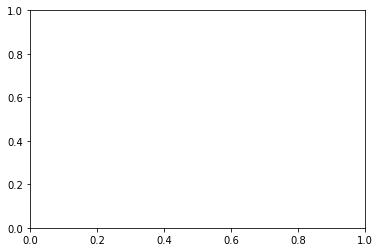

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.arange(0,15,1)
plt.plot(X, adam_loss,  color='red')
plt.plot(X, gated_loss, color='blue')
plt.plot(X, normal_loss, color='green')
plt.legend(['adam', 'gated', 'normal'])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.arange(0,15,1)
plt.plot(X, adam_accuracy,  color='red')
plt.plot(X, gated_accuracy, color='blue')
plt.plot(X, normal_accuracy, color='green')
plt.legend(['adam', 'gated', 'normal'])
plt.show()